## Training Risk-Aware-VAE

### Load MNIST

In [1]:
import torch
from dataset import read_mnist
from torch.utils.data import DataLoader
from utils import *

torch.manual_seed(2)

In [2]:
mnist_train, mnist_val, mnist_test = read_mnist()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

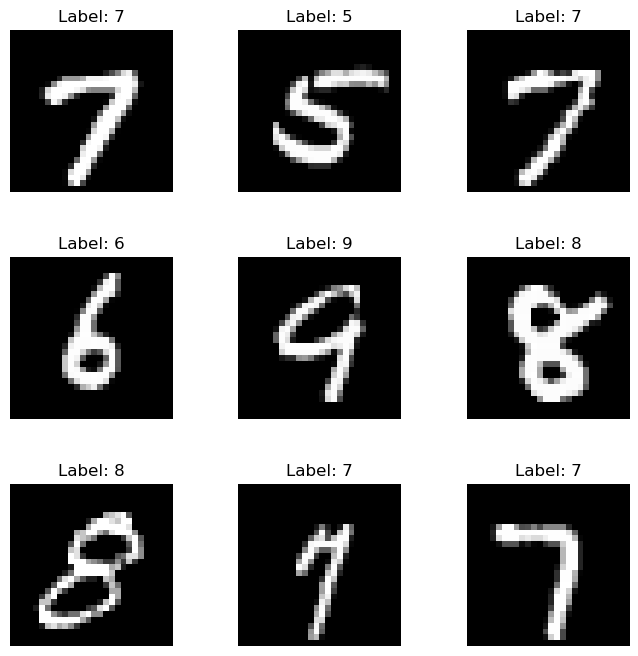

In [3]:
# some visualizations
train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
visualize_dataset_in_grid(train_features, train_labels)

### Train VAE

In [4]:
from train import train_VAE, vanilla_config, two_layer_config

Vanilla VAE

In [5]:
config = {"img_size": 28 * 28, 
          "latent_dim": 20,
          "layer_config": two_layer_config,
          "subsample": 1,
          "device": device,
          "risk_aware": "neutral",
          "risk_q": 0.5,
          "batch_aware": True,
          "save_model": True,
          "epochs": 5,}

In [6]:
train_VAE(config, mnist_train, mnist_val)

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:14<00:00, 52.79it/s]


Epoch: 1, train loss: 153.8796, dev loss: 124.5365


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 58.60it/s]


Epoch: 2, train loss: 118.7253, dev loss: 114.8935


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 58.78it/s]


Epoch: 3, train loss: 112.1952, dev loss: 110.6016


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:13<00:00, 56.97it/s]


Epoch: 4, train loss: 109.1339, dev loss: 108.4152


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:13<00:00, 57.32it/s]


Epoch: 5, train loss: 107.1010, dev loss: 106.8130


Risk-aware VAE

In [7]:
for t in ["seeking", "abiding"]:
    for q in [0.5, 0.7, 0.9]:
        config["risk_aware"] = t
        config["risk_q"] = q
        train_VAE(config, mnist_train, mnist_val)

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:13<00:00, 57.62it/s]


Epoch: 1, train loss: 118.0376, dev loss: 233.3883


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:13<00:00, 55.13it/s]


Epoch: 2, train loss: 88.8209, dev loss: 265.1642


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:13<00:00, 54.97it/s]


Epoch: 3, train loss: 82.9567, dev loss: 248.6469


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:13<00:00, 53.74it/s]


Epoch: 4, train loss: 80.4003, dev loss: 269.8731


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:14<00:00, 52.61it/s]


Epoch: 5, train loss: 78.5860, dev loss: 278.4535


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:14<00:00, 51.76it/s]


Epoch: 1, train loss: 133.3136, dev loss: 181.4921


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:16<00:00, 45.39it/s]


Epoch: 2, train loss: 101.2492, dev loss: 195.3277


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 47.42it/s]


Epoch: 3, train loss: 95.6507, dev loss: 193.9384


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:16<00:00, 46.75it/s]


Epoch: 4, train loss: 92.7548, dev loss: 195.0382


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:16<00:00, 44.38it/s]


Epoch: 5, train loss: 90.8613, dev loss: 206.4238


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:17<00:00, 42.24it/s]


Epoch: 1, train loss: 146.5777, dev loss: 132.3120


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:17<00:00, 43.65it/s]


Epoch: 2, train loss: 112.2096, dev loss: 127.0179


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 49.98it/s]


Epoch: 3, train loss: 105.9056, dev loss: 125.3048


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:14<00:00, 51.60it/s]


Epoch: 4, train loss: 103.0376, dev loss: 125.7228


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:14<00:00, 50.13it/s]


Epoch: 5, train loss: 101.2062, dev loss: 126.9711


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:16<00:00, 45.64it/s]


Epoch: 1, train loss: 183.1305, dev loss: 133.8142


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:16<00:00, 46.61it/s]


Epoch: 2, train loss: 141.7234, dev loss: 121.1006


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 47.38it/s]


Epoch: 3, train loss: 132.5923, dev loss: 116.6549


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:16<00:00, 46.34it/s]


Epoch: 4, train loss: 128.3290, dev loss: 114.0673


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:27<00:00, 26.84it/s]


Epoch: 5, train loss: 125.5998, dev loss: 112.0043


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:21<00:00, 35.37it/s]


Epoch: 1, train loss: 170.7560, dev loss: 127.5975


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:16<00:00, 45.58it/s]


Epoch: 2, train loss: 131.7026, dev loss: 117.0967


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 48.66it/s]


Epoch: 3, train loss: 124.5634, dev loss: 113.5785


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:16<00:00, 46.73it/s]


Epoch: 4, train loss: 121.1224, dev loss: 111.3174


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 48.41it/s]


Epoch: 5, train loss: 118.8427, dev loss: 110.0181


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 47.72it/s]


Epoch: 1, train loss: 160.4745, dev loss: 124.9170


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 48.53it/s]


Epoch: 2, train loss: 123.7957, dev loss: 114.6838


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 48.04it/s]


Epoch: 3, train loss: 117.4247, dev loss: 110.6132


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:15<00:00, 48.24it/s]


Epoch: 4, train loss: 114.3151, dev loss: 109.0503


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:16<00:00, 46.52it/s]


Epoch: 5, train loss: 112.4346, dev loss: 107.7332


### Model Evaluation

In [6]:
val_dataloader = DataLoader(mnist_val, batch_size=64, shuffle=True)

In [4]:
config = {"risk_aware": "neutral",
          "risk_q": 0.5,
          "batch_aware": True}

dict_models = {"vanilla": load_model(config)}

In [5]:
for t in ["seeking", "abiding"]:
    for q in [0.5, 0.7, 0.9]:
        config["risk_aware"] = t
        config["risk_q"] = q
        dict_models[f"{t}_{q}"] = load_model(config)

In [7]:
dict_recon = dict()
for model in dict_models:
    dict_recon[model] = compute_recon_loss(dict_models[model], BCE_loss, val_dataloader, device)

100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 100.22it/s]


Comparing vanilla VAE with seeking_0.5 VAE


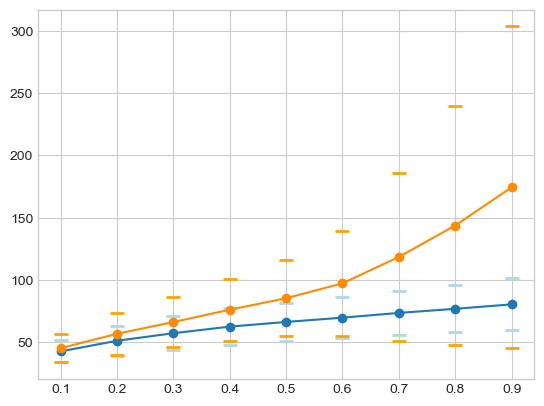

Comparing vanilla VAE with seeking_0.7 VAE


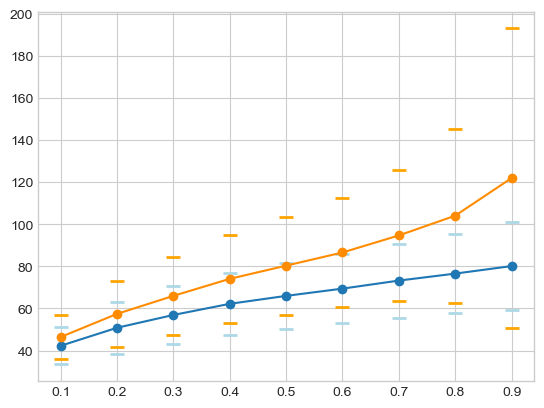

Comparing vanilla VAE with seeking_0.9 VAE


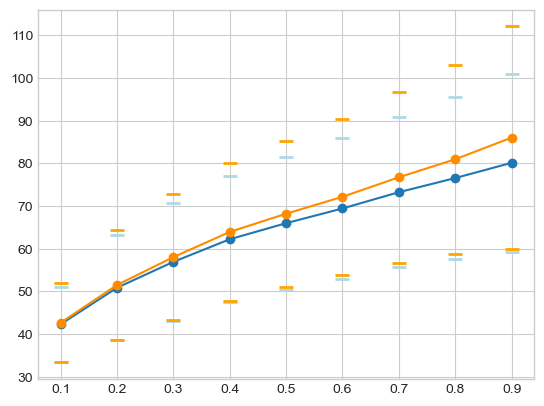

Comparing vanilla VAE with abiding_0.5 VAE


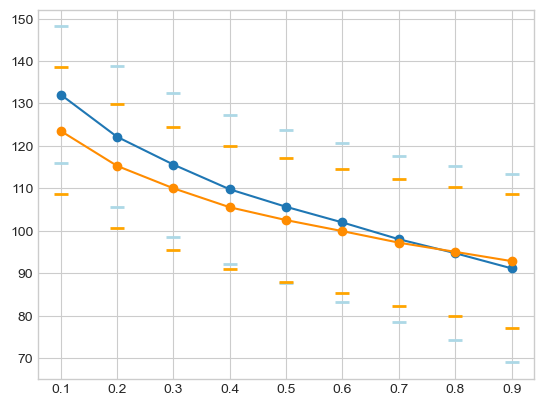

Comparing vanilla VAE with abiding_0.7 VAE


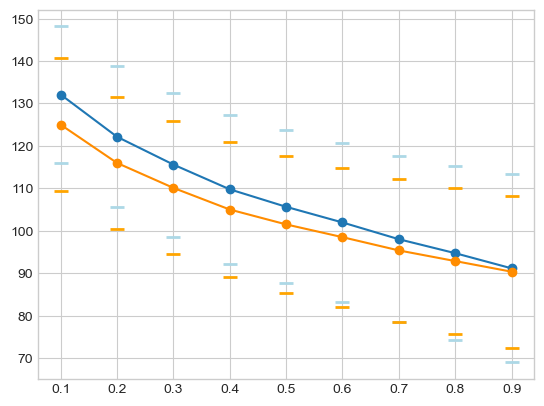

Comparing vanilla VAE with abiding_0.9 VAE


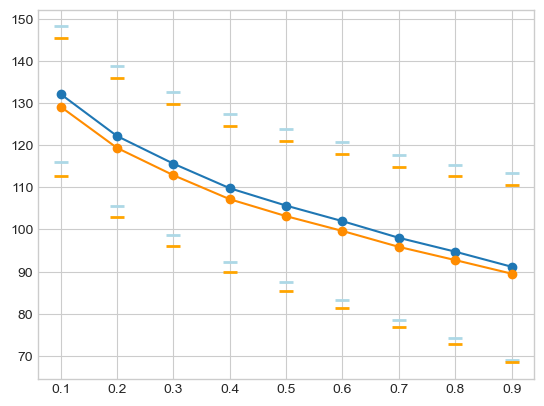

In [14]:
vanilla_loss = dict_recon["vanilla"][1]
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for model in dict_recon:
    if model != "vanilla":
        print(f"Comparing vanilla VAE with {model} VAE")
        loss = dict_recon[model][1]
        # vanilla shown in blue, alternative shown in orange
        if model.split("_")[0] == "seeking":
            plot_loss(vanilla_loss, loss, True, quantiles)
        else:
            plot_loss(vanilla_loss, loss, False, quantiles)    

### Deprecated

#### Using reconstruction loss as a metric

Preparation

Pro: Allows evaluation of the quality of a single image

Con: Comparison can only be made with fixed pairs of input and output

In [13]:
recon_samples_a, list_recon_loss_a = compute_recon_loss(vae_vanilla, val_dataloader, device)
recon_samples_b, list_recon_loss_b = compute_recon_loss(vae_rs, val_dataloader, device)

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:52<00:00,  3.57it/s]


##### Image/Sub-sample-wise comparison

Distribution of reconstruction loss

Model A: Loss minimum: 26.677104949951172, Loss maximum: 450.67510986328125
Model B: Loss minimum: 25.630939483642578, Loss maximum: 1763.93994140625


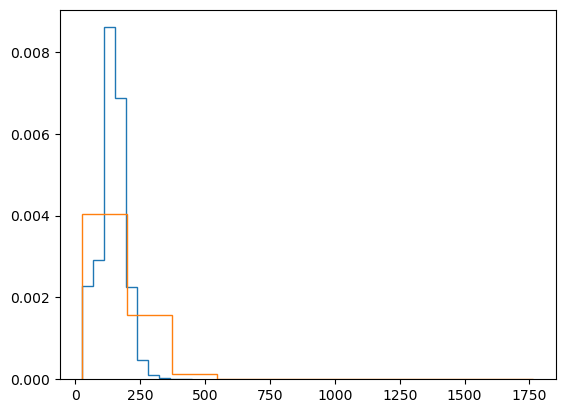

In [14]:
plot_metric(reorder(list_recon_loss_a, by="image"), reorder(list_recon_loss_b, by="image"), metric="Loss")

Plot 3 best images

In [15]:
best_imgs_a, best_imgs_loss_a = best_images(recon_samples_a, reorder(list_recon_loss_a, by="image"))
best_imgs_b, best_imgs_loss_b = best_images(recon_samples_b, reorder(list_recon_loss_b, by="image"))

Reconstruction loss: 26.677104949951172
Reconstruction loss: 26.82931900024414
Reconstruction loss: 27.030473709106445
Reconstruction loss: 27.13467788696289
Reconstruction loss: 27.139835357666016
Reconstruction loss: 27.175064086914062
Reconstruction loss: 27.190448760986328
Reconstruction loss: 27.24215316772461
Reconstruction loss: 27.492589950561523
Reconstruction loss: 27.49808120727539
Reconstruction loss: 25.630939483642578
Reconstruction loss: 25.692420959472656
Reconstruction loss: 25.740867614746094
Reconstruction loss: 25.78542709350586
Reconstruction loss: 25.79538345336914
Reconstruction loss: 25.796855926513672
Reconstruction loss: 25.847919464111328
Reconstruction loss: 25.8925838470459
Reconstruction loss: 25.922195434570312
Reconstruction loss: 26.00283432006836


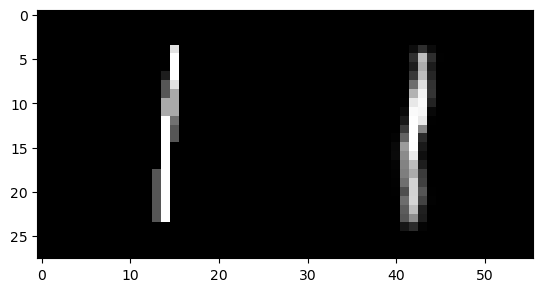

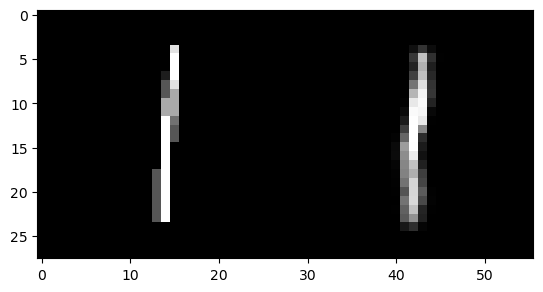

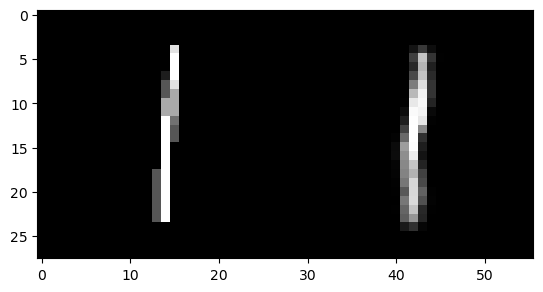

In [16]:
plot_best_images(best_imgs_a)

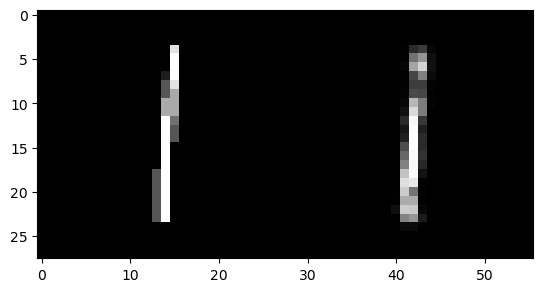

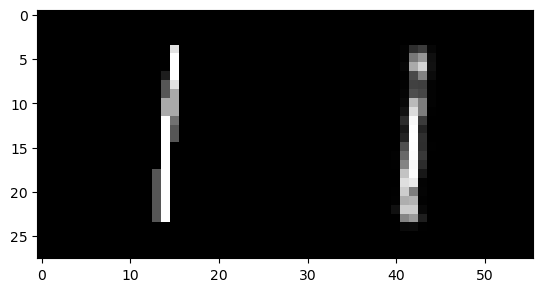

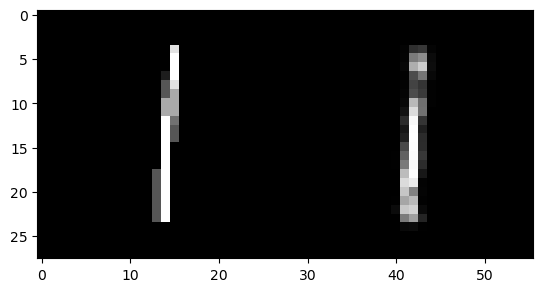

In [17]:
plot_best_images(best_imgs_b)

2 sample t-test for mean reconstruction loss in 10 best images

In [18]:
t_test(best_imgs_loss_a, best_imgs_loss_b)

Significant difference, t-statistics: 15.091571713416434, p-value: 1.164162675030635e-11


##### Batch-wise comparison

Distribution of reconstruction loss

Model A: Loss minimum: 127.50531005859375, Loss maximum: 161.2773895263672
Model B: Loss minimum: 150.25570678710938, Loss maximum: 198.0965576171875


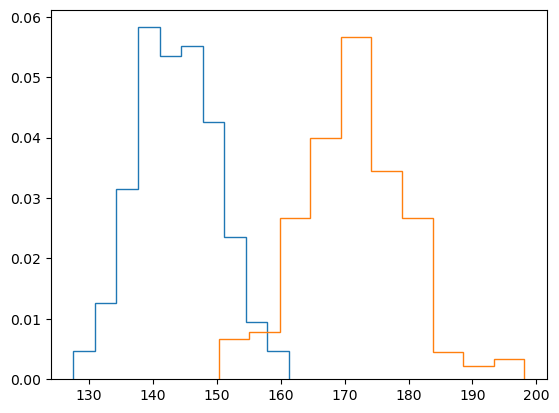

In [19]:
plot_metric(reorder(list_recon_loss_a, by="batch"), reorder(list_recon_loss_b, by="batch"), metric="Loss")

Plot images in best batch

In [20]:
best_batch_a, best_batch_loss_a = best_batch(recon_samples_a, reorder(list_recon_loss_a, by="batch"), reorder(list_recon_loss_a, by="image_nested"))
best_batch_b, best_batch_loss_b = best_batch(recon_samples_b, reorder(list_recon_loss_b, by="batch"), reorder(list_recon_loss_b, by="image_nested"))

Loss on best batch: 127.50531005859375
Loss on best batch: 150.25570678710938


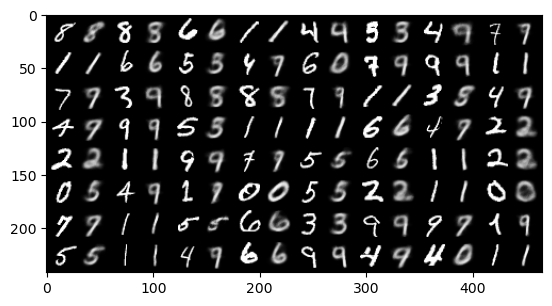

In [21]:
plot_best_batch(best_batch_a)

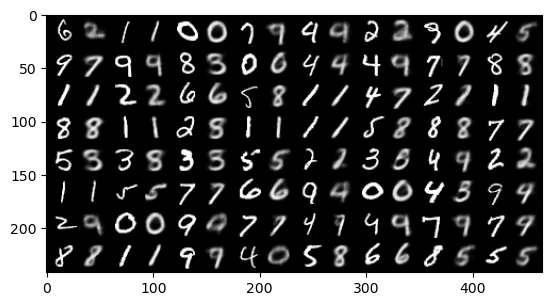

In [22]:
plot_best_batch(best_batch_b)

2 sample t-test for mean reconstruction loss in best batches

In [23]:
t_test(best_batch_loss_a, best_batch_loss_b)

Significant difference, t-statistics: -21.16280038139314, p-value: 9.848882265357774e-98


#### Using 1NN and KMMD as metric

Pro: Allows evaluation of the quality of any image -> allows assessment of generative ability

Con: Comparison can only be made between batches

Preparation

In [24]:
list_samples_a, list_mu_real_a, list_mu_gen_a = generated_embedding(vae_vanilla, 2, device, val_dataloader)
list_samples_b, list_mu_real_b, list_mu_gen_b = generated_embedding(vae_rs, 2, device, val_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 46.13it/s]


In [25]:
list_acc_a = knn_by_batch(list_mu_real_a, list_mu_gen_a)
list_acc_b = knn_by_batch(list_mu_real_b, list_mu_gen_b)

In [26]:
list_mmd_a = mmd_by_batch(list_mu_real_a, list_mu_gen_a)
list_mmd_b = mmd_by_batch(list_mu_real_b, list_mu_gen_b)

Distribution of image quality

Model A: 1NN Accuracy minimum: 0.390625, 1NN Accuracy maximum: 0.75
Model B: 1NN Accuracy minimum: 0.4140625, 1NN Accuracy maximum: 0.7265625


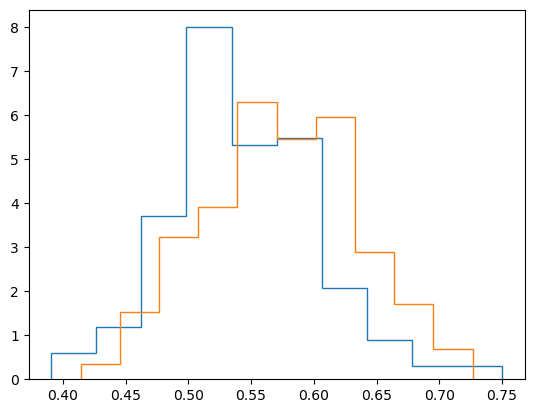

In [27]:
plot_metric(list_acc_a, list_acc_b, metric="1NN Accuracy")

Model A: KMMD minimum: 0.08056049048900604, KMMD maximum: 0.195184588432312
Model B: KMMD minimum: 0.09757381677627563, KMMD maximum: 0.2039104849100113


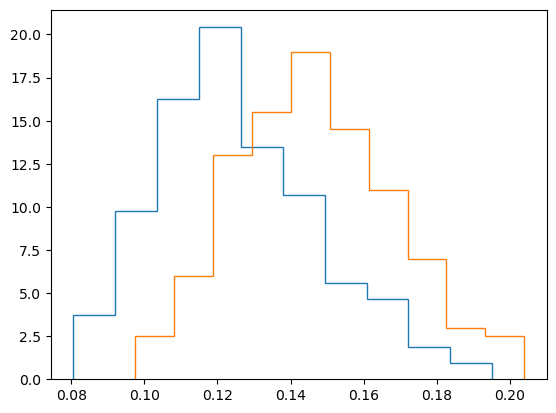

In [28]:
plot_metric(list_mmd_a, list_mmd_b, metric="KMMD")

Plot images in best batch

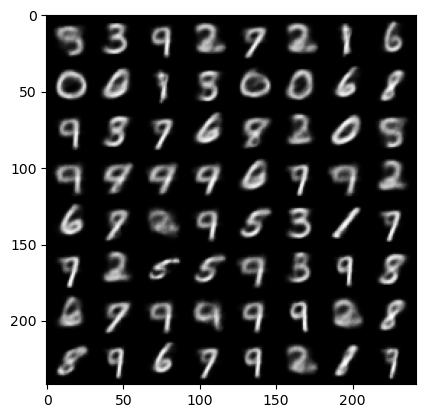

In [29]:
plot_metric_best_batch(list_samples_a, list_acc_a)

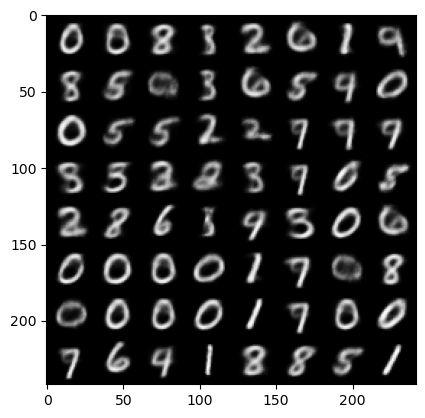

In [30]:
plot_metric_best_batch(list_samples_b, list_acc_b)

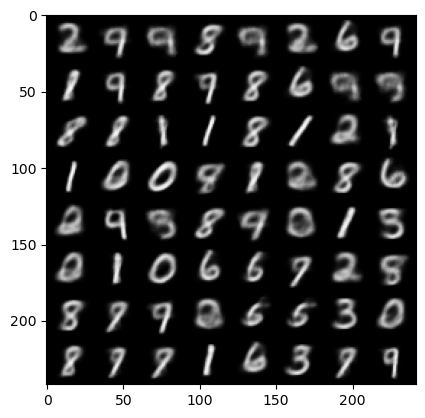

In [31]:
plot_metric_best_batch(list_samples_a, list_mmd_a)

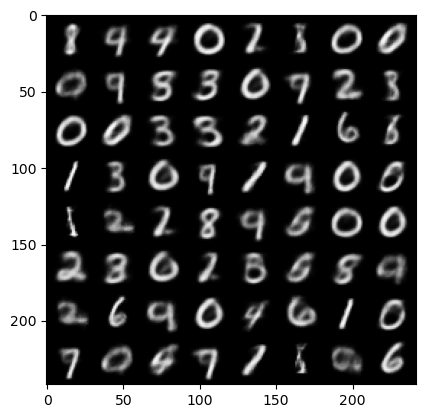

In [32]:
plot_metric_best_batch(list_samples_b, list_mmd_b)

2 sample t-test for image quality

In [35]:
t_test(list_acc_a, list_acc_b)

Significant difference, t-statistics: -2.5586429126824606, p-value: 0.010901168350411015


In [36]:
t_test(list_mmd_a, list_mmd_b)

No significant difference, t-statistics: -0.22520896423156242, p-value: 0.8219397192409174
